# Data Deduplication using Clustering
**Objective**: Learn and implement data deduplication techniques.

**Task**: Deduplication Using K-means Clustering

**Steps**:
1. Data Set: Download a dataset containing duplicate customer records.
2. Preprocess: Standardize the data to ensure better clustering.
3. Apply K-means: Use K-means clustering to find and group similar customer records.
4. Identify Duplicates: Identify and remove duplicates within clusters.

Initial DataFrame shape: (580, 7)
Sample of initial DataFrame:
   Customer_ID  Age  Annual_Income  Number_of_Purchases  Last_Purchase_Amount  \
0         2585   25          51453                   20                454.96   
1          277   57          97641                   31                352.42   
2          104   26         137112                   41                 43.61   
3          177   45         119112                   44                611.66   
4          456   32          91886                   35                189.17   

          City Email_Domain  
0      Houston    gmail.com  
1     New York    yahoo.com  
2  Los Angeles    gmail.com  
3  Los Angeles    yahoo.com  
4      Phoenix  outlook.com  

Sample of Scaled Data:
        Age  Annual_Income  Number_of_Purchases  Last_Purchase_Amount
0 -1.263117      -1.046245            -0.321826             -0.191616
1  0.853673       0.319269             0.449782             -0.541774
2 -1.196967       1.486200          

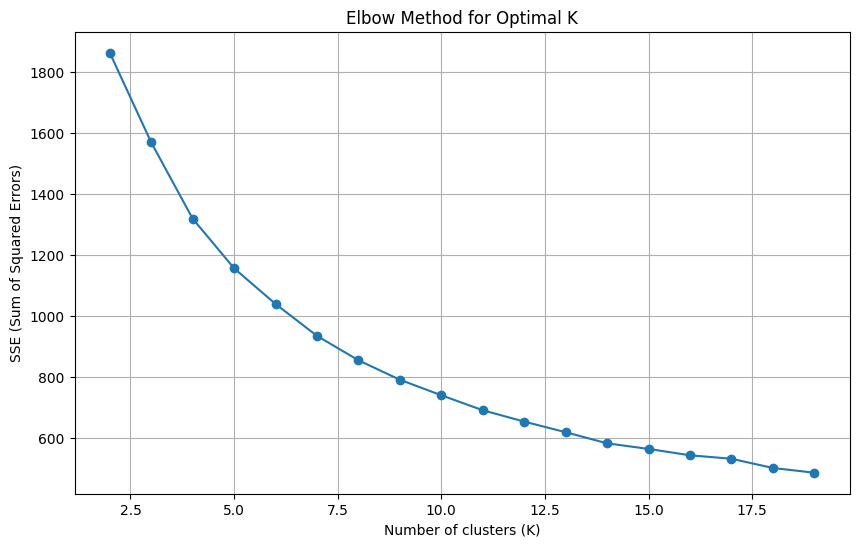


Applying K-means with K = 10

DataFrame with Cluster Assignments:
   Customer_ID  Age  Annual_Income  Number_of_Purchases  Last_Purchase_Amount  \
0         2585   25          51453                   20                454.96   
1          277   57          97641                   31                352.42   
2          104   26         137112                   41                 43.61   
3          177   45         119112                   44                611.66   
4          456   32          91886                   35                189.17   

          City Email_Domain  Cluster  
0      Houston    gmail.com        9  
1     New York    yahoo.com        0  
2  Los Angeles    gmail.com        5  
3  Los Angeles    yahoo.com        0  
4      Phoenix  outlook.com        5  

Number of records per cluster:
Cluster
0    53
1    46
2    72
3    62
4    62
5    53
6    50
7    67
8    57
9    58
Name: count, dtype: int64

Total potential duplicates identified and removed: 50
Original Da

NameError: name 'customer_records_before_dups' is not defined

In [ ]:
# write your code from here
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

def generate_customer_data(num_records=1000, num_duplicates=150, num_near_duplicates=100):
    data = {
        'Customer_ID': range(num_records),
        'Age': np.random.randint(18, 70, num_records),
        'Annual_Income': np.random.randint(30000, 150000, num_records),
        'Number_of_Purchases': np.random.randint(1, 50, num_records),
        'Last_Purchase_Amount': np.random.uniform(10, 1000, num_records).round(2),
        'City': np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'], num_records),
        'Email_Domain': np.random.choice(['gmail.com', 'yahoo.com', 'outlook.com', 'company.com'], num_records)
    }
    df = pd.DataFrame(data)

    # Introduce exact duplicates
    duplicate_rows = df.sample(n=num_duplicates, replace=False, random_state=42).copy()
    duplicate_rows['Customer_ID'] = np.random.randint(1000, 2000, num_duplicates)
    df = pd.concat([df, duplicate_rows], ignore_index=True)

    # Introduce near-duplicates (slight variations)
    near_duplicate_rows = df.sample(n=num_near_duplicates, replace=False, random_state=100).copy()
    near_duplicate_rows['Customer_ID'] = np.random.randint(2000, 3000, num_near_duplicates)
    near_duplicate_rows['Age'] = near_duplicate_rows['Age'] + np.random.randint(-2, 3, num_near_duplicates)
    near_duplicate_rows['Annual_Income'] = near_duplicate_rows['Annual_Income'] + np.random.randint(-1000, 1000, num_near_duplicates)
    near_duplicate_rows['Last_Purchase_Amount'] = near_duplicate_rows['Last_Purchase_Amount'] + np.random.uniform(-5, 5, num_near_duplicates).round(2)
    for i in range(len(near_duplicate_rows)):
        if np.random.rand() < 0.1:
            near_duplicate_rows.iloc[i, near_duplicate_rows.columns.get_loc('City')] = np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'])
        if np.random.rand() < 0.05:
            near_duplicate_rows.iloc[i, near_duplicate_rows.columns.get_loc('Email_Domain')] = np.random.choice(['gmail.com', 'yahoo.com', 'outlook.com', 'company.com'])

    df = pd.concat([df, near_duplicate_rows], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    return df

customer_df = generate_customer_data(num_records=500, num_duplicates=50, num_near_duplicates=30)
print(f"Initial DataFrame shape: {customer_df.shape}")
print("Sample of initial DataFrame:")
print(customer_df.head())

numerical_features = ['Age', 'Annual_Income', 'Number_of_Purchases', 'Last_Purchase_Amount']
X = customer_df[numerical_features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_features, index=customer_df.index)

print("\nSample of Scaled Data:")
print(X_scaled_df.head())

sse = []
k_range = range(2, 20)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

optimal_k = 10

print(f"\nApplying K-means with K = {optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_df['Cluster'] = kmeans.fit_predict(X_scaled)

print("\nDataFrame with Cluster Assignments:")
print(customer_df.head())
print(f"\nNumber of records per cluster:\n{customer_df['Cluster'].value_counts().sort_index()}")

deduplicated_records = []
duplicates_found_count = 0

for cluster_id in range(optimal_k):
    cluster_df = customer_df[customer_df['Cluster'] == cluster_id].copy()
    if cluster_df.empty:
        continue
    cluster_df['features_tuple'] = list(zip(*[cluster_df[col] for col in numerical_features]))
    grouped = cluster_df.groupby('features_tuple')
    for name, group in grouped:
        if len(group) > 1:
            duplicates_found_count += (len(group) - 1)
            deduplicated_records.append(group.iloc[0])
        else:
            deduplicated_records.append(group.iloc[0])

final_df = pd.DataFrame(deduplicated_records).drop(columns=['Cluster', 'features_tuple'])

print(f"\nTotal potential duplicates identified and removed: {duplicates_found_count}")
print(f"Original DataFrame size: {len(customer_df)}")
print(f"Deduplicated DataFrame size: {len(final_df)}")
print("\nSample of Deduplicated DataFrame:")
print(final_df.head())

# --- Improved Verification Steps ---
print("\n--- Verification of Deduplication ---")
# Check for exact duplicates on numerical features before and after
num_exact_dups_before = customer_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) before deduplication: {num_exact_dups_before}")

num_exact_dups_after = final_df.duplicated(subset=numerical_features).sum()
print(f"Number of exact duplicates (on numerical features) after deduplication: {num_exact_dups_after}")

# You can also pick a specific record that was generated as a duplicate/near-duplicate
# and try to see its presence. This is harder with random generation.
# A simpler verification is to check if the total count of 'unique' rows
# based on numerical features matches the final_df length if duplicates were removed.
num_unique_numerical_features_original = customer_df.drop_duplicates(subset=numerical_features).shape[0]
print(f"Number of unique records (based on numerical features) in original DF: {num_unique_numerical_features_original}")
print(f"Number of records in final (deduplicated) DF: {len(final_df)}")

if num_exact_dups_after == 0:
    print("Success: No exact duplicates (on numerical features) remaining in the deduplicated DataFrame.")
else:
    print("Warning: Some exact duplicates (on numerical features) still remain in the deduplicated DataFrame.")